# Finetuning Pre-Trained Models

In this notebook, we will see how can we fine-tune a pre-trained model on our dataset using __HuggingFace Libraries__.

In [1]:
from IPython.display import Image, display

## Steps in Fine-tuning

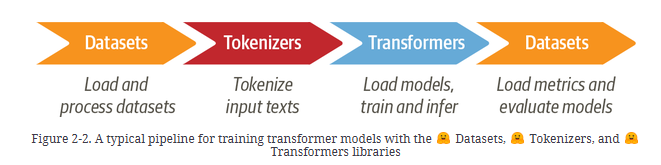

In [2]:
display(Image(filename='./Pics_03_StepsInFinetuning.png', width=600, height=200))

## Download/Load Local Dataset

We will download the dataset from __HuggingFace Hub__ using the __HuggingFace dataset library__.

In [3]:
from datasets import load_dataset # !pip install datasets 
# (just like pip install transofrmers for HuggingFace Transformer library)

# We can list all the datasets using list_dataset() function
# "emotion" is one of the datasets available on the Hub.
# The below command will download the dataset from Hub and load
# into the notebook.
emotions = load_dataset("emotion")

In [4]:
# We can load our own dataset as well
full_data = load_dataset(
    "csv", data_files= {
        "train": "../../Datasets/Jumble_Unjumble/OriginalFull_Train.txt",
        "test": "../../Datasets/Jumble_Unjumble/OriginalFull_Test.txt",
    },sep="\t", names=["Source","Target"]
)
full_data # It is a dict of Dataset objects (train and test)

DatasetDict({
    train: Dataset({
        features: ['Source', 'Target'],
        num_rows: 36414
    })
    test: Dataset({
        features: ['Source', 'Target'],
        num_rows: 4046
    })
})

In [5]:
# Dataset is one of the core data structures of HuggingFace Dataset library.
# It can be thought of as python list: we can get the length, or access its elements by index.
train_ds = full_data["train"]
len(train_ds), train_ds[0] # Each element in the Dataset object (train_ds) is a dict.

(36414,
 {'Source': 'paper. on cap, sitting man a bench, and in t-shirt, a A shorts park reading a',
  'Target': 'A man in a t-shirt, shorts and cap, sitting on a park bench, reading a paper.'})

In [6]:
# Just like python list, Dataset object has many attributes, 2 of them (features, and num_rows)
# are already visible here. To get all the attributes,
# we can use dir() function. __getitem()__ is also an attribute
# which allows list like indexing of Dataset object.
for el in dir(train_ds):
    if el[0] in ["c","f","n","t"]: print(el,end = "; ") # printing attributes starting from "c","f","n","t"

cache_files; cast; cast_column; citation; class_encode_column; cleanup_cache_files; column_names; config_name; features; filter; flatten; flatten_indices; format; formatted_as; from_buffer; from_csv; from_dict; from_file; from_generator; from_json; from_list; from_pandas; from_parquet; from_polars; from_spark; from_sql; from_text; num_columns; num_rows; take; to_csv; to_dict; to_iterable_dataset; to_json; to_list; to_pandas; to_parquet; to_polars; to_sql; to_tf_dataset; train_test_split; 

## Process Text Data

While __Word Level__ tokenization is good, it has many problems: words can include _declinations, conjugations, or misspellings_, the size of the vocabulary can easily grow into the __millions__. We do not want such a large vocabulary, as then the __EmbeddingLayer__ weight itself will be of the order of __1B__. (1M Vocab_Size X 1000 Dim Embedding).

One common approach is to limit the vocabulary and discard rare words by considering, say, the 100,000 most common words in the corpus. Words that are not part of the vocabulary are classified as “unknown” and mapped to a shared __UNK__ token. The downside of this approach as obvious is loss of information, since the model has no information about words associated with __UNK__.

The other idea is to use __Subword Tokenization__.
- It splits __rare words__ into __smaller units__ to allow the model to deal with complex words, __misspellings__, and __Out of Vocab__ words.
- It keeps frequent words as __unique entities__ so that we can keep the length of our inputs to a manageable size.
- It is __learned__ from the _pretraining corpus using a mix of statistical rules and algorithms_.

There are several algorihtms for __Subword Tokenization__. Two of the most common are: __WordPiece__ (mostly used in BERT based models) and __Byte-Pair Encoding__ (used in BART like models).

### Loading the Tokenizer

In [7]:
from transformers import BartTokenizer
# Download the pre-trained tokenizer used in BART-Base model.
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base",add_prefix_space=True, is_pretokenized=True)
# Access the vocab file:
vocab_file = tokenizer.get_vocab()
print(type(vocab_file),len(vocab_file), tokenizer.vocab_size, tokenizer.model_max_length)

<class 'dict'> 50265 50265 1000000000000000019884624838656


In [8]:
encoded_text = tokenizer(train_ds[0]["Source"])
print(encoded_text) # encoded_text is a dict, with keys "input_ids" and "attention_mask"

{'input_ids': [0, 2225, 4, 15, 2927, 6, 2828, 313, 10, 3638, 6, 8, 11, 326, 12, 8674, 6, 10, 83, 13344, 2221, 2600, 10, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['<s>', 'Ġpaper', '.', 'Ġon', 'Ġcap', ',', 'Ġsitting', 'Ġman', 'Ġa', 'Ġbench', ',', 'Ġand', 'Ġin', 'Ġt', '-', 'shirt', ',', 'Ġa', 'ĠA', 'Ġshorts', 'Ġpark', 'Ġreading', 'Ġa', '</s>']


In [10]:
# Function to clean tokens
def clean_bpe_tokens(tokens, unwanted_char="Ġ"):
    return [token.lstrip(unwanted_char) for token in tokens]

cleaned_tokens = clean_bpe_tokens(tokens)
print("Cleaned Tokens:", cleaned_tokens)

Cleaned Tokens: ['<s>', 'paper', '.', 'on', 'cap', ',', 'sitting', 'man', 'a', 'bench', ',', 'and', 'in', 't', '-', 'shirt', ',', 'a', 'A', 'shorts', 'park', 'reading', 'a', '</s>']


## Tokenizing data

In [11]:
def tokenize_function(batch):
    source_encoded = tokenizer(batch["Source"], padding=True, truncation=True)
    target_encoded = tokenizer(batch["Target"], padding=True, truncation=True)
    source_encoded["labels"] = target_encoded["input_ids"] # This step is most important
    # We are only returning the source_encoding
    # We don't care about target_encoding as long as we get its
    # 'input_ids' as 'labels'. We do not require 'attention_mask'
    # of target.
    return source_encoded 

In [12]:
full_data_encoded = full_data.map(tokenize_function, batched=True, batch_size=None)
full_data_encoded # 2 more column names are added (input_ids, labels)

Map:   0%|          | 0/4046 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


DatasetDict({
    train: Dataset({
        features: ['Source', 'Target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 36414
    })
    test: Dataset({
        features: ['Source', 'Target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4046
    })
})

In [28]:
print(
    "Sample Training point:",full_data_encoded["train"][0]
)
# By default, 'labels' column is not created.
# 'labels' here == 'input_ids' of Target
# 'attention_mask' == 'attention_mask' of Source only.
# As we had discarded the target_encoding in the
# tokenizer_function()

Sample Training point: {'Source': 'paper. on cap, sitting man a bench, and in t-shirt, a A shorts park reading a', 'Target': 'A man in a t-shirt, shorts and cap, sitting on a park bench, reading a paper.', 'input_ids': [0, 2225, 4, 15, 2927, 6, 2828, 313, 10, 3638, 6, 8, 11, 326, 12, 8674, 6, 10, 83, 13344, 2221, 2600, 10, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [0, 83, 313, 11, 10, 326, 12, 8674, 6, 13344, 8, 2927, 6, 2828, 15, 10, 2221, 3638, 6, 2600, 10, 2225, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## Load Pre-trained model

In [13]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import BartForConditionalGeneration, DataCollatorForSeq2Seq

# Load the BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

## Predictions from Pre-trained model

In [14]:
import torch

# Load the fine-tuned BART model and tokenizer
model_name_to_load = "facebook/bart-base"
tokenizer_name_to_load = "facebook/bart-base"
loaded_tokenizer = BartTokenizer.from_pretrained(tokenizer_name_to_load)
loaded_model = BartForConditionalGeneration.from_pretrained(model_name_to_load)

In [15]:
# Function to generate predictions
def generate_prediction(model, tokenizer, input_text, max_length=50):
    # Tokenize the input text
    inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)

    # Generate predictions
    with torch.no_grad():
        generated_ids = model.generate(inputs["input_ids"], max_length=max_length)

    # Decode the generated tokens to get the prediction
    prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    return prediction


In [16]:
input_text = full_data["test"][5]
print(input_text)
prediction = generate_prediction(loaded_model, loaded_tokenizer, input_text["Source"])
print(f"Prediction: {prediction}")

{'Source': 'jeans. red faded street and in the blue on shorts with a toddler top a in khaki top a and white tank European A walks boy woman', 'Target': 'A toddler boy in a red tank top and khaki shorts walks on the European street with a woman in a white top and faded blue jeans.'}
Prediction: jeans. red faded street and in the blue on shorts with a toddler top a in khaki top a and white tank top A walks boy woman


## Training And Saving the Model + Tokenizer

In [17]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=False,  # Use fp16 if you have a compatible GPU
)

D:\OtherSoftwares\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=full_data_encoded['train'],
    eval_dataset=full_data_encoded['test'],
    tokenizer=tokenizer
)


C:\Users\nprak\AppData\Local\Temp\ipykernel_16352\2114520301.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.121300,0.093129
2,0.089100,0.081463


D:\OtherSoftwares\Python312\Lib\site-packages\transformers\modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=2276, training_loss=0.3231494011904108, metrics={'train_runtime': 10027.3988, 'train_samples_per_second': 7.263, 'train_steps_per_second': 0.227, 'total_flos': 1864700323799040.0, 'train_loss': 0.3231494011904108, 'epoch': 2.0})

In [20]:
model.save_pretrained("results/fine-tuned-model")

In [21]:
tokenizer.save_pretrained("results/fine-tuned-tokenizer")

('results/fine-tuned-tokenizer\\tokenizer_config.json',
 'results/fine-tuned-tokenizer\\special_tokens_map.json',
 'results/fine-tuned-tokenizer\\vocab.json',
 'results/fine-tuned-tokenizer\\merges.txt',
 'results/fine-tuned-tokenizer\\added_tokens.json')

## Predicting from Fine-Tuned Model

In [22]:
# Load the fine-tuned BART model and tokenizer
model_name_to_load = "results/fine-tuned-model"
tokenizer_name_to_load = "results/fine-tuned-tokenizer"
loaded_tokenizer = BartTokenizer.from_pretrained(tokenizer_name_to_load)
loaded_model = BartForConditionalGeneration.from_pretrained(model_name_to_load)

In [23]:
# Function to generate predictions
def generate_prediction(model, tokenizer, input_text, max_length=50):
    # Tokenize the input text
    inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)

    # Generate predictions
    with torch.no_grad():
        generated_ids = model.generate(inputs["input_ids"], max_length=max_length)

    # Decode the generated tokens to get the prediction
    prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    return prediction

In [24]:
input_text = full_data["test"][5]
print(input_text)
prediction = generate_prediction(loaded_model, loaded_tokenizer, input_text["Source"])
print(f"Prediction: {prediction}")

{'Source': 'jeans. red faded street and in the blue on shorts with a toddler top a in khaki top a and white tank European A walks boy woman', 'Target': 'A toddler boy in a red tank top and khaki shorts walks on the European street with a woman in a white top and faded blue jeans.'}
Prediction:  A woman in a blue tank top and white shorts walks on the street with a toddler in a red and white striped top and jeans.
